In [1]:
import aerialbot
import requests
import re
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
# override configured options with values supplied via the cli

point = (1.319335, 103.737142) # just pick a coord somewhere in the middle of the scene
max_meters_per_pixel = 0.2
width = 2000
height = 2000
image_width = None#1000
image_height = None
direction = aerialbot.ViewDirection("downward")
google_maps_version = aerialbot.GOOGLE_MAPS_VERSION_FALLBACK
max_tries = 10
quality_check_delta = 2
apply_adjustments = False
# Which level of quality to target during JPEG compression (between 0 and 100,
# higher values imply higher quality but larger files).
image_quality = 100#90
tile_path_template = os.path.join(os.getcwd(),"aerialbot-tiles","{angle_if_oblique}z{zoom}x{x}y{y}-{hash}.jpg")
tile_url_template = "googlemaps"
# tile_url_template = "https://khms2.google.com/kh/v={google_maps_version}?x={x}&y={y}&z={zoom}"
image_path_template = os.path.join(os.getcwd(),"aerialbot-{datetime}-{direction}-{latitude},{longitude}-{width}x{height}m-z{zoom}.jpg")
logfile = os.path.join(os.getcwd(),"aerialbot.log")
sw_point = (1.319000, 103.736650) #(1.319010, 103.736650)
ne_point = (1.319806, 103.737532)
rect = aerialbot.GeoRect(
    aerialbot.GeoPoint(sw_point[0], sw_point[1]),
    aerialbot.GeoPoint(ne_point[0], ne_point[1]))
rect

GeoRect(GeoPoint(1.319, 103.73665), GeoPoint(1.319806, 103.737532))

In [3]:
def main(point, rect,max_meters_per_pixel,width,height,image_height,image_width,direction,
         google_maps_version,max_tries,quality_check_delta,apply_adjustments,image_quality,
         tile_path_template, tile_url_template, image_path_template,
         logfile):
    LOGGER = aerialbot.Log(logfile)

    if tile_url_template == "googlemaps":
        LOGGER.info("Using Google Maps preset...")
        tile_url_template = "https://khms2.google.com/kh/v={google_maps_version}?x={x}&y={y}&z={zoom}"

    if "{google_maps_version}" in tile_url_template:
        LOGGER.info("Determining current Google Maps version and patching tile URL template...")

        # set to fallback initially, will be overwritten if current version can
        # be determined
        google_maps_version = aerialbot.GOOGLE_MAPS_VERSION_FALLBACK

        try:
            google_maps_page = requests.get("https://maps.googleapis.com/maps/api/js", headers={"User-Agent": aerialbot.USER_AGENT}).content
            match = re.search(rb'null,\[\[\"https:\/\/khms0\.googleapis\.com\/kh\?v=([0-9]+)', google_maps_page)
            
            if match:
                google_maps_version = match.group(1).decode('ascii')
                LOGGER.debug(google_maps_version)
            else:
                # print(f"Unable to extract current version, proceeding with outdated version {google_maps_version} instead.")
                LOGGER.warning(f"Unable to extract current version, proceeding with outdated version {google_maps_version} instead.")
        except requests.RequestException:
            # print(f"Unable to load Google Maps, proceeding with outdated version {google_maps_version} instead.")
            LOGGER.warning(f"Unable to load Google Maps, proceeding with outdated version {google_maps_version} instead.")

        tile_url_template = tile_url_template.replace("{google_maps_version}", google_maps_version)

    aerialbot.MapTile.tile_path_template = tile_path_template
    aerialbot.MapTile.tile_url_template = tile_url_template

    # geowidth = width
    # geoheight = height
    foreshortening_factor = 1

    # process max_meters_per_pixel setting
    if image_width is None and image_height is None:
        assert max_meters_per_pixel is not None
    elif image_height is None:
        max_meters_per_pixel = (max_meters_per_pixel or 1) * (width / image_width)
    elif image_width is None:
        max_meters_per_pixel = (max_meters_per_pixel or 1) * (height / image_height) / foreshortening_factor
    else:

        # if both are set, effectively use whatever imposes a tighter constraint
        if width / image_width <= (height / image_height) / foreshortening_factor:
            max_meters_per_pixel = (max_meters_per_pixel or 1) * (width / image_width)
        else:
            max_meters_per_pixel = (max_meters_per_pixel or 1) * (height / image_height) / foreshortening_factor

    # process image width and height for scaling
    if image_width is not None or image_height is not None:
        if image_height is None:
            image_height = height * (image_width / width) / foreshortening_factor
        elif image_width is None:
            image_width = width * (image_height / height) * foreshortening_factor

    p = aerialbot.GeoPoint(point[0], point[1])
    
    for tries in range(0, max_tries):
        if tries > max_tries:
            raise RuntimeError("too many retries – maybe there's no internet connection? either that, or your max_meters_per_pixel setting is too low")

        LOGGER.debug(p)

        LOGGER.info("Computing required tile zoom level at point...")
        zoom = p.compute_zoom_level(max_meters_per_pixel)
        LOGGER.debug(zoom)

        LOGGER.info("Generating rectangle with your selected width and height around point...")
        # rect = aerialbot.GeoRect.around_geopoint(p, geowidth, geoheight)
        LOGGER.debug(rect)

        LOGGER.info("Turning rectangle into a grid of map tiles at the required zoom level...")
        grid = aerialbot.MapTileGrid.from_georect(rect, zoom, direction)
        LOGGER.debug(grid)

        LOGGER.info("Checking quality of imagery available for the map tile grid...")
        if not grid.has_high_quality_imagery(quality_check_delta):
            LOGGER.info(f"Not good enough, let's try this again (retry {tries})...")
        else:
            LOGGER.info("Lookin' good, let's proceed!")
            break

    LOGGER.info("Downloading tiles...")
    grid.download()

    LOGGER.info("Stitching tiles together into an image...")
    grid.stitch()
    image = aerialbot.MapTileImage(grid.image)

    LOGGER.info("Cropping image to match the chosen area width and height...")
    LOGGER.debug((width, height))
    image.crop(zoom, direction, rect)

    if image_width is not None or image_height is not None:
        LOGGER.info("Scaling image...")
        LOGGER.debug((image_width, image_height))
        image.scale(image_width, image_height)

    if apply_adjustments:
        LOGGER.info("Enhancing image...")
        image.enhance()

    LOGGER.info("Saving image to disk...")
    image_path = image_path_template.format(
        datetime=datetime.today().strftime("%Y-%m-%dT%H.%M.%S"),
        direction=direction,
        latitude=p.lat,
        longitude=p.lon,
        width=width,
        height=height,
        max_meters_per_pixel=max_meters_per_pixel,
        xmin=grid.at(0, 0).x,
        xmax=grid.at(0, 0).x+grid.width,
        ymin=grid.at(0, 0).y,
        ymax=grid.at(0, 0).y+grid.height,
        zoom=zoom,
        georect=f"sw{rect.sw.lat},{rect.sw.lon}ne{rect.ne.lat},{rect.ne.lon}"
    )
    LOGGER.debug(image_path)
    d = os.path.dirname(image_path)
    if not os.path.isdir(d):
        os.makedirs(d)
    image.save(image_path, image_quality)

In [4]:
main(point, rect, max_meters_per_pixel,width,height,image_height,image_width,direction,
         google_maps_version,max_tries,quality_check_delta,apply_adjustments,image_quality,
         tile_path_template, tile_url_template, image_path_template,
         logfile)

Using Google Maps preset...
Determining current Google Maps version and patching tile URL template...
968
GeoPoint(1.319335, 103.737142)
Computing required tile zoom level at point...
20
Generating rectangle with your selected width and height around point...
GeoRect(GeoPoint(1.319, 103.73665), GeoPoint(1.319806, 103.737532))
Turning rectangle into a grid of map tiles at the required zoom level...
MapTileGrid([[MapTile(20, downward, 826442, 520443), MapTile(20, downward, 826442, 520444), MapTile(20, downward, 826442, 520445)], [MapTile(20, downward, 826443, 520443), MapTile(20, downward, 826443, 520444), MapTile(20, downward, 826443, 520445)], [MapTile(20, downward, 826444, 520443), MapTile(20, downward, 826444, 520444), MapTile(20, downward, 826444, 520445)], [MapTile(20, downward, 826445, 520443), MapTile(20, downward, 826445, 520444), MapTile(20, downward, 826445, 520445)]])
Checking quality of imagery available for the map tile grid...
Lookin' good, let's proceed!
░░░░░░░░
░░░░░░░░

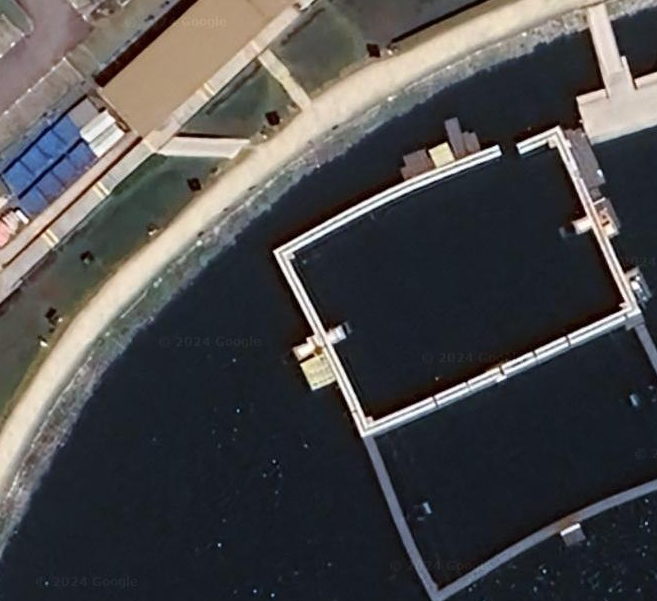

In [1]:
import PIL.Image as Image
import numpy as np

Image.open(r"aerialbot-2024-02-11T17.00.57-downward-1.319335,103.737142-2000x2000m-z20.jpg")